## 总结一下课题的代码（Prezel Model）

### 1.标准代码部分（DMRG）

In [1]:
import numpy as np
import numpy.linalg as LA
import scipy.sparse.linalg as LAs
import Sub180221 as Sub
import math,copy
import matplotlib.pyplot as plt

def normalize_max(matrix):
    max_val = np.max(np.abs(matrix))
    return matrix / max_val if max_val != 0 else matrix

def contains_inf_or_nan(arr):
    return np.any(np.isnan(arr)) or np.any(np.isinf(arr))

def GetMpo_Kagome(Dp,Omega,Delta,sqrtV):     #### Default: Dp=2
    w = Omega
    d = Delta
    I, Sp, Sm, Z, X, Y = Sub.SpinOper(Dp)
    Z*=2
    X*=2
    Y*=2
    n = np.array([[1,0],[0,0]])
    N = sqrtV*n
    P = np.array([[0,0],[0,1]])
    Dmpo = 8
    M = w*X + d*Z
    Mpo = [np.zeros((Dmpo, Dp, Dmpo, Dp)) for _ in range(6)]
    
    for i in range(6):
        Mpo[i][0,:,0,:] = I
        Mpo[i][7,:,7,:] = I
        Mpo[i][0,:,7,:] = M
        
    Mpo[0][0,:,2,:] = N
    Mpo[0][0,:,3,:] = N
    Mpo[0][0,:,5,:] = N
    Mpo[0][0,:,6,:] = N
    Mpo[0][2,:,2,:] = I
    Mpo[0][3,:,3,:] = I
    Mpo[0][4,:,4,:] = I
    Mpo[0][1,:,7,:] = N
    
    Mpo[1][0,:,4,:] = N
    Mpo[1][0,:,5,:] = N
    Mpo[1][0,:,6,:] = N
    Mpo[1][2,:,7,:] = N
    Mpo[1][3,:,3,:] = I
    Mpo[1][4,:,4,:] = I
    Mpo[1][5,:,5,:] = I
    Mpo[1][6,:,6,:] = I
    
    Mpo[2][0,:,1,:] = N
    Mpo[2][0,:,3,:] = N
    Mpo[2][0,:,5,:] = N
    Mpo[2][3,:,7,:] = N
    Mpo[2][4,:,4,:] = I
    Mpo[2][5,:,5,:] = I
    Mpo[2][6,:,6,:] = I
    
    Mpo[3][0,:,2,:] = N
    Mpo[3][0,:,4,:] = N
    Mpo[3][0,:,6,:] = N
    Mpo[3][4,:,7,:] = N
    Mpo[3][1,:,1,:] = I
    Mpo[3][3,:,3,:] = I
    Mpo[3][5,:,5,:] = I
    Mpo[3][6,:,6,:] = I
    
    Mpo[4][0,:,1,:] = N
    Mpo[4][0,:,3,:] = N
    Mpo[4][0,:,6,:] = N
    Mpo[4][5,:,7,:] = N
    Mpo[4][1,:,1,:] = I
    Mpo[4][2,:,2,:] = I
    Mpo[4][3,:,3,:] = I
    Mpo[4][4,:,4,:] = I
    Mpo[4][6,:,6,:] = I
    
    Mpo[5][0,:,2,:] = N
    Mpo[5][0,:,4,:] = N
    Mpo[5][6,:,7,:] = N
    Mpo[5][1,:,1,:] = I
    Mpo[5][2,:,2,:] = I
    Mpo[5][3,:,3,:] = I
    Mpo[5][4,:,4,:] = I
    
    return Mpo

### Initialize Mps
def InitMps(Ns, Dp, Ds):    #无需改动,初始化一个MPS
    '''
    Given the system size, initialize an Mps in Canonical form. Ds is the truncation index of the virtual dimension.
    -------------------
    Ns: int, system size
    Dp: int, physical dimension, default is 2
    Ds: int, truncation index of the virtual dimension
    -------------------
    return
    T: list, Mps
    '''
    T = [None] * Ns
    
    # Randomly initialize Mps
    for i in range(Ns):
        Dl = min(Dp**i, Dp**(Ns-i), Ds)
        Dr = min(Dp**(i+1), Dp**(Ns-i-1), Ds)
        T[i] = np.random.rand(Dl, Dp, Dr)
        
    # Canonical form
    U = np.eye(np.shape(T[-1])[-1])
    for i in range(Ns-1, 0, -1):
        U, T[i] = Sub.Mps_LQP(T[i], U)    #####
        U = normalize_max(U)      # Otherwise, L may become very large, so large that the system considers it as inf
        
    return T

# Initialize Hamiltonian
def IniH(Mpo,T):      # 后面有一个改动的版本，因为会需要不同地方的MPO
    Ns = len(T)  # We might want to take multiples of 12
    Dmpo = np.shape(Mpo[0])[0]
    HL = [None]*Ns
    HR = [None]*Ns
    HL[0] = np.zeros((1,Dmpo,1))
    HL[0][0,0,0] = 1.0
    HR[-1] = np.zeros((1,Dmpo,1))
    HR[-1][0,-1,0] = 1.0
    
    for i in range(Ns-1,0,-1):  # Don't get i = 0
        HR[i-1] = Sub.NCon([HR[i],T[i],Mpo[i%6],np.conj(T[i])],[[1,3,5],[-1,2,1],[-2,2,3,4],[-3,4,5]])
    
    return HL,HR

# Optimize a single site
def OptTsite(Mpo_single,HL,HR,T,Method=0):
    DT = np.shape(T)   # What is the shape of T
    Dl = np.prod(DT)   # Dl = D1*D2*...*DN
    
    if Method == 0:
        A = Sub.NCon([HL,Mpo_single,HR],[[-1,1,-4],[1,-5,2,-2],[-6,2,-3]])
        A = Sub.Group(A,[[0,1,2],[3,4,5]])
        Eig,V = LAs.eigsh(A,k=1,which = 'SA')
        T = np.reshape(V,DT)
        
    if Method == 1:
        def UpdateV(V):
            V = np.reshape(V,DT)
            V = Sub.NCon([HL,V,Mpo_single,HR],[[-1,3,1],[1,2,4],[3,2,5,-2],[4,5,-3]])
            V = np.reshape(V,Dl)
            return V
        
        V0 = np.reshape(T,Dl)
        MV = LAs.LinearOperator((Dl,Dl),matvec=UpdateV)
        Eig, V = LAs.eigsh(MV, k=1, which='SA', v0=V0, maxiter=10000)  # 例如，将最大迭代次数设置为1000
		# print(Eig)
        T = np.reshape(V,DT)
        Eig = np.real(Eig)
    if Method ==2: #######################这个纯纯特殊目的
        def UpdateV(V):
            V = np.reshape(V,DT)
            V = Sub.NCon([HL,V,Mpo_single,HR],[[-1,3,1],[1,2,4],[3,2,5,-2],[4,5,-3]])
            V = np.reshape(V,Dl)
            return V
        
        V0 = np.reshape(T,Dl)
        MV = LAs.LinearOperator((Dl,Dl),matvec=UpdateV)
        Eigs, Vs = LAs.eigsh(MV, k=2, which='SA', v0=V0, maxiter=10000)  # 例如，将最大迭代次数设置为1000
		# print(Eig)
        Eig = Eigs[1]
        V = Vs[:, 1]
        T = np.reshape(V,DT)
        Eig = np.real(Eig)
    
    return T,Eig

# Optimize wave function
def OptT_naive(Mpo,HL,HR,T):    # 正常版本的OptTsite
    '''
    Sweep back and forth to optimze the Mps
    -------------------
    Mpo: list, Mpo (len = 6)
    HL = initial_HL
    HR = initial_HR
    T = initial_Mps
    -------------------
    return
    T: list, optimized Mps
    '''
    Ns = len(T)
    Eng0 = np.zeros(Ns)
    Eng1 = np.zeros(Ns)
    for r in range(100):   # The number of sweeps
        if r == 99:
            print('Reaching the limit!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
        print('Sweep:',r)
        for i in range(Ns-1):   # Sweep to the right
            T[i],Eng1[i] = OptTsite(Mpo[i%6],HL[i],HR[i],T[i],Method=1)
            T[i],U = Sub.Mps_QR0P(T[i])
            HL[i+1] = Sub.NCon([HL[i],np.conj(T[i]),Mpo[i%6],T[i]],[[1,3,5],[1,2,-1],[3,4,-2,2],[5,4,-3]])
            T[i+1] = np.tensordot(U,T[i+1],(1,0))
            
        for i in range(Ns-1,0,-1):
            T[i],Eng1[i] = OptTsite(Mpo[i%6],HL[i],HR[i],T[i],Method=1)
            U,T[i] = Sub.Mps_LQ0P(T[i])
            HR[i-1] = Sub.NCon([HR[i],T[i],Mpo[i%6],np.conj(T[i])],[[1,3,5],[-1,2,1],[-2,2,3,4],[-3,4,5]])
            T[i-1] = np.tensordot(T[i-1],U,(2,0))
        #print(Eng1)
        if abs(Eng1[1]-Eng0[1]) < 1.0e-8:      # Stop sweeping if the energy converges     #考虑微扰的阶数，这里会不会有问题？十的多少次方才够用
            break
        Eng0 = copy.copy(Eng1)
    
    
    #print('Eigenvalue per site:',Eng1 /float(Ns))
    EEE = Eng1[1] /float(Ns)
    return T,EEE


### 2.对于Wave Function(也就是T)的操作

In [2]:
######## 1. 正则化MPS

# 把一个left-canonicalized的MPS变成以N为中心central-canonicalized的         #######貌似搞错了，可能得到的实际上是把右正则化的变成中心Canonicalized
def canonicalize_mps(T,N):   
    ''' 
    Given a left-canonicalized MPS, we can make it a central-canonicalized MPS
    给定一个左正则化的MPS，把它变成中心正则化的MPS
    返回值是一个中心正则化的MPS和中心处的张量
    '''
    # N is the index of our center site
    # T is left-canonicalized
    T_copy = copy.deepcopy(T)
    Ns = len(T)
    for i in range(N):
        T_copy[i],U = Sub.Mps_QR0P(T_copy[i])
        if i==N-1:
            Values = U
        T_copy[i+1] = np.tensordot(U,T_copy[1+i],(1,0))
        
    return T_copy,T_copy[N]

######## 2. 计算sigmaz值

def calculate_sigmaz(T,N):   # 算的是N处的sigmaZ值
    opt_T,site_N = canonicalize_mps(T,N)   #正则化以后只有中心处的张量有用，其他张量收缩成identity
    Z = np.array([[1,0],[0,-1]])
    Z_value = Sub.NCon([site_N,Z,np.conj(site_N)],[[1,2,3],[2,4],[1,4,3]])
    return Z_value

def plot_sigmaz(T):   # 画出sigmaZ值随着site的变化
    Ns = len(T)
    sigmaz_list = []
    for i in range(Ns):
        sigmaz_list.append(calculate_sigmaz(T, i))
    plt.plot(range(Ns), sigmaz_list)
    plt.scatter(range(Ns), sigmaz_list)
    plt.xlabel('site')
    plt.ylabel('sigmaZ')
    plt.title('sigmaZ vs site')
    plt.show()


######## 3. 计算纠缠熵

def Entropy_optmized_version_free(T,N):    # 算的是N处的纠缠熵
    ''' 
    名字有点复杂，其实就是算的是N处的纠缠熵
    optimized是因为以前有一个很烂的版本
    free是因为可以任意选取计算纠缠熵的点位
    '''
    Ns = len(T)
    T = copy.deepcopy(T)  # 深拷贝 T
    for i in range(N):
        T[i],U = Sub.Mps_QR0P(T[i])
        if i==N-1:
            Values = U
        T[i+1] = np.tensordot(U,T[1+i],(1,0))
    Values = Values@Values.T.conj()
    evals = np.linalg.eigvalsh(Values)
    evals = evals[evals > 0]
    
    #'''
    T[N-1] = Sub.Group(T[N-1],[[0,1],[2]])
    T[N]   = Sub.Group(T[N],[[0],[1,2]])
    Mat = Sub.NCon([T[N-1],T[N]],[[-1,1],[1,-2]])
    #UU,SS,VV,Dc = Sub.SplitSvd_Lapack(Mat,8,0)
    UU,SS,Vh = np.linalg.svd(Mat)
    Values = SS
    evals = np.square(Values)
    evals = evals[evals > 0]
    #'''
    
    return -np.sum(evals * np.log(evals))

def plot_entropy(T):   # 画出纠缠熵随着site的变化
    Ns = len(T)
    entropy_list = []
    for i in range(Ns):
        entropy_list.append(Entropy_optmized_version_free(T, i))
    plt.plot(range(Ns), entropy_list)
    plt.scatter(range(Ns), entropy_list)
    plt.xlabel('site')
    plt.ylabel('entropy')
    plt.title('entropy vs site')
    plt.show()

### 3. 兼容不均匀的$\Delta$的新函数

In [3]:
def Mpo_choose_version1(Mpo1,Mpo2,Mpo3,Ns=192):
    #作用是把中间的两个变成Mpo2，其余的变成Mpo1或者Mpo3
    Mpo_list = [None]*Ns
    for i in range(Ns):
        if i < Ns/2:     # Ns/2 = 96, 也即0-95
            Mpo_list[i] = Mpo1[i%6]
        elif i < Ns/2 + 2:   # 96-97
            Mpo_list[i] = Mpo2[i%6]
        else:
            Mpo_list[i] = Mpo3[i%6]
    return Mpo_list

def Mpo_choose_version2(Mpo1,Mpo2,Mpo3,Ns=192):   # 这个是4-site的正确版本
    #作用是把中间的四个变成Mpo2，其余的变成Mpo1或者Mpo3
    Mpo_list = [None]*Ns
    for i in range(Ns):
        if i < Ns/2:     # Ns/2 = 96, 也即0-95
            Mpo_list[i] = Mpo1[i%6]
        elif i < Ns/2 + 4:   # 96-99
            Mpo_list[i] = Mpo2[i%6]
        else:
            Mpo_list[i] = Mpo3[i%6]
    return Mpo_list

def Mpo_choose_version3(Mpo1,Mpo2,Mpo3,Ns=192):
    # 这个可能才是2-site的正确版本
    Mpo_list = [None]*Ns   
    for i in range(Ns):
        if i < Ns/2+4:     # Ns/2 = 96, 也即0-99
            Mpo_list[i] = Mpo1[i%6]
        elif i < Ns/2 + 4 + 2:   # 100-101
            Mpo_list[i] = Mpo2[i%6]
        else:
            Mpo_list[i] = Mpo3[i%6]
    return Mpo_list


def IniH_multiple(Mpo_list,T):    
    '''
    IniH的改动版本，可以兼容不同delta的MPO
    '''
    ### 我打算做的改动是先将所有的mpo存在一个Mpo_list里面，然后再将这个Mpo_list传入这个函数
    Ns = len(T)  # We might want to take multiples of 12
    #print(np.shape(Mpo_list[0])[0])
    Dmpo = np.shape(Mpo_list[0])[0]
    HL = [None]*Ns
    HR = [None]*Ns
    HL[0] = np.zeros((1,Dmpo,1))
    HL[0][0,0,0] = 1.0
    HR[-1] = np.zeros((1,Dmpo,1))
    HR[-1][0,-1,0] = 1.0
    
    for i in range(Ns-1,0,-1):  # Don't get i = 0
        #print('i=',i)
        #print('np.shape(HR[i])=',np.shape(HR[i]))
        #print('np.shape(T[i])=',np.shape(T[i]))
        #print('np.shape(Mpo_list[i])=',np.shape(Mpo_list[i]))
        HR[i-1] = Sub.NCon([HR[i],T[i],Mpo_list[i],np.conj(T[i])],[[1,3,5],[-1,2,1],[-2,2,3,4],[-3,4,5]])
    
    return HL,HR

def OptT_multiple(Mpo_list,HL,HR,T):      # 改动是：能够接受mpo——list
    '''
    Sweep back and forth to optimze the Mps
    -------------------
    Mpo_list：list, Mpo (len = Ns)
    HL = initial_HL
    HR = initial_HR
    T = initial_Mps
    -------------------
    return
    T: list, optimized Mps
    '''
    Ns = len(T)
    Eng0 = np.zeros(Ns)
    Eng1 = np.zeros(Ns)
    for r in range(100):   # The number of sweeps
        if r == 99:
            print('Reaching the limit!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
        #print('-------------------------------------------')
        print('Sweep:',r)
        for i in range(Ns-1):   # Sweep to the right
            T[i],Eng1[i] = OptTsite(Mpo_list[i],HL[i],HR[i],T[i],Method=1)
            T[i],U = Sub.Mps_QR0P(T[i])
            HL[i+1] = Sub.NCon([HL[i],np.conj(T[i]),Mpo_list[i],T[i]],[[1,3,5],[1,2,-1],[3,4,-2,2],[5,4,-3]])
            T[i+1] = np.tensordot(U,T[i+1],(1,0))
            
        for i in range(Ns-1,0,-1):
            T[i],Eng1[i] = OptTsite(Mpo_list[i],HL[i],HR[i],T[i],Method=1)
            U,T[i] = Sub.Mps_LQ0P(T[i])
            HR[i-1] = Sub.NCon([HR[i],T[i],Mpo_list[i],np.conj(T[i])],[[1,3,5],[-1,2,1],[-2,2,3,4],[-3,4,5]])
            T[i-1] = np.tensordot(T[i-1],U,(2,0))
        #print(Eng1)
        if abs(Eng1[1]-Eng0[1]) < 1.0e-8:     
            break
        Eng0 = copy.copy(Eng1)
    
    
    #print('Eigenvalue per site:',Eng1 /float(Ns))
    EEE = Eng1[1] /float(Ns)
    return T,EEE

In [4]:
from scipy.linalg import qr
def left_canonicalize_mpo(MPO):
    MPO_a = copy.deepcopy(MPO)
    a,b,c,d = np.shape(MPO_a)
    MPO_a = Sub.Group(MPO_a,[[0,1,3],[2]])
    # 对MPO_a进行QR分解
    MPO_a,U = qr(MPO_a)
    MPO_a = np.reshape(MPO_a,(a,b,c,d))
    
    return MPO_a
    

In [5]:
## 示例代码，如果要跑可以把引号去掉
'''
# 参数设定
Ns = 192
Dp = 2
Ds = 14
Delta1 = -1.8
Delta3 = 1
# Delta2_list是在13之间取十个数
Delta2_list = np.linspace(-1.8,1,10)
Omega = 1

E_list = []

for Delta2 in Delta2_list:
    print('Delta is :', Delta2)
    # 初始化 MPS 和 MPO
    Mpo1 = GetMpo_Kagome(Dp, Omega, Delta1, 15)
    Mpo2 = GetMpo_Kagome(Dp, Omega, Delta2, 15)
    Mpo3 = GetMpo_Kagome(Dp, Omega, Delta3, 15)
    Mpolist = Mpo_choose_version1(Mpo1,Mpo2,Mpo3,Ns)
    
    T = InitMps(Ns, Dp, Ds)

    # 初始化边界条件
    HL, HR = IniH_multiple(Mpolist, T)

    # 优化并计算能量和纠缠熵
    T, Energy = OptT_multiple(Mpolist, HL, HR, T)
    E_total = Energy*Ns
    print('Energy is :', E_total)

    E_list.append(E_total)
    
print(E_list)
# 画图
import matplotlib.pyplot as plt
plt.plot(Delta2_list,E_list)
plt.xlabel('Delta2')
plt.ylabel('Energy')
plt.title('Energy vs Delta2')
plt.show()
'''

"\n# 参数设定\nNs = 192\nDp = 2\nDs = 14\nDelta1 = -1.8\nDelta3 = 1\n# Delta2_list是在13之间取十个数\nDelta2_list = np.linspace(-1.8,1,10)\nOmega = 1\n\nE_list = []\n\nfor Delta2 in Delta2_list:\n    print('Delta is :', Delta2)\n    # 初始化 MPS 和 MPO\n    Mpo1 = GetMpo_Kagome(Dp, Omega, Delta1, 15)\n    Mpo2 = GetMpo_Kagome(Dp, Omega, Delta2, 15)\n    Mpo3 = GetMpo_Kagome(Dp, Omega, Delta3, 15)\n    Mpolist = Mpo_choose_version1(Mpo1,Mpo2,Mpo3,Ns)\n    \n    T = InitMps(Ns, Dp, Ds)\n\n    # 初始化边界条件\n    HL, HR = IniH_multiple(Mpolist, T)\n\n    # 优化并计算能量和纠缠熵\n    T, Energy = OptT_multiple(Mpolist, HL, HR, T)\n    E_total = Energy*Ns\n    print('Energy is :', E_total)\n\n    E_list.append(E_total)\n    \nprint(E_list)\n# 画图\nimport matplotlib.pyplot as plt\nplt.plot(Delta2_list,E_list)\nplt.xlabel('Delta2')\nplt.ylabel('Energy')\nplt.title('Energy vs Delta2')\nplt.show()\n"

### 4.处理激发态

In [6]:
def SSSingle_site_matrix_construct(block_left0,block_right0,T_ground0):
    ''' 
    处理一个site的矩阵，这个矩阵是一个矢量，我们需要把它变成一个矩阵，乘上他的共轭转置（是的这很抽象）
    '''
    Vec = Sub.NCon([block_left0,T_ground0,block_right0],[[1,-1],[1,-2,2],[2,-3]])
    Vec = Sub.Group(Vec,[[0,1,2]])
    # 现在Vec是一个矢量，我们需要把它变成一个矩阵，乘上他的共轭转置
    Mat = np.tensordot(Vec,np.conj(Vec),axes=0)
    return Mat

def OptTsite_GS_MPO_optimized(Mpo_single_H0,HL_0,HR_0,Mat_GG,E_penalty,T,Method=0):
    '''
    单点优化，需要知道这个点的MPO，以及左右block（也就是HL_0和HR_0）; 另外能量还需要考虑一个E_penalty带来的部分
    所以要计算特征值的矩阵是H_0+Mat_GG 
    '''
    DT = np.shape(T)   # What is the shape of T
    Dl = np.prod(DT)   # Dl = D1*D2*...*DN
    
    if Method == 0:
        A1 = Sub.NCon([HL_0,Mpo_single_H0,HR_0],[[-1,1,-4],[1,-5,2,-2],[-6,2,-3]])
        A1 = Sub.Group(A1,[[0,1,2],[3,4,5]])
        A = A1 + E_penalty*Mat_GG
        Eig,V = LAs.eigsh(A,k=1,which = 'SA')
        T = np.reshape(V,DT)
        
    if Method == 1:
        def UpdateV(V):   # 进来的V是一条腿
            V1 = np.reshape(V,DT)
            V1 = Sub.NCon([HL_0,V1,Mpo_single_H0,HR_0],[[-1,3,1],[1,2,4],[3,2,5,-2],[4,5,-3]])
            V1 = np.reshape(V1,Dl)    # 最后就是一条腿
            V2 = np.tensordot(Mat_GG,V,axes=(1,0))
            V = V1 + E_penalty*V2
            return V    # 出来的V也是一条腿
        
        V0 = np.reshape(T,Dl)
        MV = LAs.LinearOperator((Dl,Dl),matvec=UpdateV)
        Eig, V = LAs.eigsh(MV, k=1, which='SA', v0=V0, maxiter=10000)  # 例如，将最大迭代次数设置为1000
		# print(Eig)
        T = np.reshape(V,DT)
        Eig = np.real(Eig)
    
    return T,Eig



def OptT_multiple_GS_optimized(Mpo_list_H0,HL_0,HR_0,T_ground,T,E_penalty):
    Ns = len(T)
    Eng0 = np.zeros(Ns)
    Eng1 = np.zeros(Ns)
    block_left = [None]*Ns
    block_right = [None]*Ns 
    DL0 = np.shape(T_ground[0])[0]
    DR0 = np.shape(T_ground[-1])[2]
    block_left[0] = np.eye(DL0,DL0)
    block_right[-1] = np.eye(DR0,DR0)
    for i in range(len(T_ground) - 1, 0, -1):
        block_right[i-1] = Sub.NCon([block_right[i],T_ground[i],np.conj(T[i])],[[2,3],[-1,1,2],[-2,1,3]])
    
    for r in range(100):   # The number of sweeps
        if r == 99:
            print('Reaching the limit!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
        print('Sweep:',r)
        
        for i in range(Ns-1):   # Sweep to the right
            Mat_GG = SSSingle_site_matrix_construct(block_left[i],block_right[i],T_ground[i])
            T[i],Eng1[i] = OptTsite_GS_MPO_optimized(Mpo_list_H0[i],HL_0[i],HR_0[i],Mat_GG,E_penalty,T[i],Method=1)
            T[i],U = Sub.Mps_QR0P(T[i])
            HL_0[i+1] = Sub.NCon([HL_0[i],np.conj(T[i]),Mpo_list_H0[i],T[i]],[[1,3,5],[1,2,-1],[3,4,-2,2],[5,4,-3]])
            block_left[i+1] = Sub.NCon([block_left[i],T_ground[i],np.conj(T[i])],[[1,2],[1,3,-1],[2,3,-2]])
            T[i+1] = np.tensordot(U,T[i+1],(1,0))
            
        for i in range(Ns-1,0,-1):
            Mat_GG = SSSingle_site_matrix_construct(block_left[i],block_right[i],T_ground[i])
            T[i],Eng1[i] = OptTsite_GS_MPO_optimized(Mpo_list_H0[i],HL_0[i],HR_0[i],Mat_GG,E_penalty,T[i],Method=1)
            U,T[i] = Sub.Mps_LQ0P(T[i])
            HR_0[i-1] = Sub.NCon([HR_0[i],T[i],Mpo_list_H0[i],np.conj(T[i])],[[1,3,5],[-1,2,1],[-2,2,3,4],[-3,4,5]])
            block_right[i-1] = Sub.NCon([block_right[i],T_ground[i],np.conj(T[i])],[[2,3],[-1,1,2],[-2,1,3]])
            T[i-1] = np.tensordot(T[i-1],U,(2,0))
        #print(Eng1)
        if abs(Eng1[1]-Eng0[1]) < 1.0e-8:     
            break
        Eng0 = copy.copy(Eng1)
    
    
    #print('Eigenvalue per site:',Eng1 /float(Ns))
    EEE = Eng1[1] /float(Ns)
    return T,EEE


def Inner_product_MPS(T_ground,T_trial):
    Ns = len(T_ground)
    site_i = int(Ns/2)
    DL0 = np.shape(T_ground[0])[0]
    DR0 = np.shape(T_ground[-1])[2] 
    block_left = np.eye(DL0,DL0)
    block_right = np.eye(DR0,DR0)
    for i in range(site_i+1):
        block_left = Sub.NCon([block_left,T_ground[i],np.conj(T_trial[i])],[[1,2],[1,3,-1],[2,3,-2]])
    for i in range(len(T_ground) - 1, site_i, -1):
        block_right = Sub.NCon([block_right,T_ground[i],np.conj(T_trial[i])],[[2,3],[-1,1,2],[-2,1,3]])
    Vec = Sub.NCon([block_left,block_right],[[1,2],[1,2]])
    return Vec

### 5.处理局域化的激发

In [7]:


from scipy.sparse.linalg import eigsh

def localized_excitation(Mpo_list,T_ground_state,start_index,end_index):
    T_ground = copy.deepcopy(T_ground_state)  
    Ns = len(T_ground)
    Dmpo = np.shape(Mpo_list[0])[0]
    HL = [None]*Ns
    HR = [None]*Ns
    HL[0] = np.zeros((1,Dmpo,1))
    HL[0][0,0,0] = 1.0
    HR[-1] = np.zeros((1,Dmpo,1))
    HR[-1][0,-1,0] = 1.0
    for i in range(Ns-1,0,-1):   #获得一个HR[end_index]
        U,T_ground[i] = Sub.Mps_LQ0P(T_ground[i])
        T_ground[i-1] = np.tensordot(T_ground[i-1],U,(2,0))
        HR[i-1] = Sub.NCon([HR[i],T_ground[i],Mpo_list[i],np.conj(T_ground[i])],[[1,3,5],[-1,2,1],[-2,2,3,4],[-3,4,5]])
    for i in range(start_index):   #获得一个HL[start_index]
        T_ground[i],U = Sub.Mps_QR0P(T_ground[i])
        T_ground[i+1] = np.tensordot(U,T_ground[i+1],(1,0))
        HL[i+1] = Sub.NCon([HL[i],np.conj(T_ground[i]),Mpo_list[i],T_ground[i]],[[1,3,5],[1,2,-1],[3,4,-2,2],[5,4,-3]])

    
    HL_star = Sub.NCon([HL[start_index],Mpo_list[start_index]],[[-1,1,-2],[1,-3,-4,-5]])
    HL_star = Sub.Group(HL_star,[[0,4],[3],[1,2]])
    for i in range(start_index,end_index):
        i_star = i+1
        HL_star = Sub.NCon([HL_star,Mpo_list[i_star]],[[-1,1,-2],[1,-3,-4,-5]])
        HL_star = Sub.Group(HL_star,[[0,4],[3],[1,2]])
    Mat = Sub.NCon([HL_star,HR[end_index]],[[-1,1,-3],[-4,1,-2]])
    Mat = Sub.Group(Mat,[[0,1],[2,3]])  
    Eig ,V = eigsh(Mat, k=2, which='SA')
    # 提取第二小的特征值
    first_E = Eig[0]
    second_smallest_eigenvalue = Eig[1]
    
    return second_smallest_eigenvalue,first_E

def localized_excitation_shit(Mpo_list,T_ground_state,start_index,end_index):
    T_ground = copy.deepcopy(T_ground_state)   # 万万不能直接赋值，这样只是引用，会导致T_ground_state被改变
    #print('st1',Sub.NCon([T_ground[start_index],np.conj(T_ground[start_index])],[[1,2,3],[1,2,3]]))
    Ns = len(T_ground)
    Dmpo = np.shape(Mpo_list[0])[0]
    HL = [None]*Ns
    HR = [None]*Ns
    HL[0] = np.zeros((1,Dmpo,1))
    HL[0][0,0,0] = 1.0
    HR[-1] = np.zeros((1,Dmpo,1))
    HR[-1][0,-1,0] = 1.0
    for i in range(Ns-1,0,-1):   #获得一个HR[end_index]
        #HR[i-1] = Sub.NCon([HR[i],T_ground[i],Mpo_list[i],np.conj(T_ground[i])],[[1,3,5],[-1,2,1],[-2,2,3,4],[-3,4,5]])
        U,T_ground[i] = Sub.Mps_LQ0P(T_ground[i])
        T_ground[i-1] = np.tensordot(T_ground[i-1],U,(2,0))
        HR[i-1] = Sub.NCon([HR[i],T_ground[i],Mpo_list[i],np.conj(T_ground[i])],[[1,3,5],[-1,2,1],[-2,2,3,4],[-3,4,5]])
    #print('st2',Sub.NCon([T_ground[start_index],np.conj(T_ground[start_index])],[[1,2,3],[1,2,3]]))
    for i in range(start_index):   #获得一个HL[start_index]
        T_ground[i],U = Sub.Mps_QR0P(T_ground[i])
        T_ground[i+1] = np.tensordot(U,T_ground[i+1],(1,0))
        HL[i+1] = Sub.NCon([HL[i],np.conj(T_ground[i]),Mpo_list[i],T_ground[i]],[[1,3,5],[1,2,-1],[3,4,-2,2],[5,4,-3]])
    #print('st3',Sub.NCon([T_ground[start_index],np.conj(T_ground[start_index])],[[1,2,3],[1,2,3]]))
    #print('st4',Sub.NCon([T_ground[end_index],np.conj(T_ground[end_index])],[[1,2,3],[1,2,3]]))
    middle_H = Mpo_list[start_index]
    for i in range(start_index,end_index):
        print('here is one',i)
        middle_H = Sub.NCon([middle_H,Mpo_list[i+1]],[[-1,-2,1,-6],[1,-3,-4,-5]])
        middle_H = Sub.Group(middle_H,[[0],[1,2],[3],[4,5]])
    print('shape',np.shape(middle_H))
    Mat = Sub.NCon([HL[start_index],middle_H,HR[end_index]],[[-1,1,-4],[1,-5,2,-2],[-6,2,-3]])
    Mat = Sub.Group(Mat,[[0,1,2],[3,4,5]])
    '''
    vec = Sub.NCon([T_ground[start_index],T_ground[end_index]],[[-1,-2,1],[1,-3,-4]])
    vec = Sub.Group(vec,[[0,1,2,3]])
    print('shape',np.shape(vec))
    print('shape',np.shape(Mat))
    print('Value',Sub.NCon([vec,Mat,np.conj(vec)],[[2],[1,2],[1]]))
    '''
    
    #print('shape',np.shape(Mat))
    #print(np.shape(Mat))
    Eig ,V = eigsh(Mat, k=2, which='SA')
    # 提取第二小的特征值
    first_E = Eig[0]
    second_smallest_eigenvalue = Eig[1]
    
    return second_smallest_eigenvalue,first_E

In [8]:
def combined_MPO(Mpolist, num):
    Ns = len(Mpolist)
    #print('Ns',Ns)
    length = Ns//num   
    #print('length',length)
    Mpo_combined = [None]*length
    for i in range(length): 
        #print('i',i)
        m1 = Mpolist[i*num]
        for j in range(1,num):
            m1 = Sub.NCon([m1,Mpolist[i*num+j]],[[-1,-2,1,-6],[1,-3,-4,-5]])
            m1 = Sub.Group(m1,[[0],[1,2],[3],[4,5]])
        Mpo_combined[i] = m1
        
    return Mpo_combined

### Box图像

## 可以跑的东西：

In [ ]:
from joblib import Parallel, delayed
import numpy as np
import matplotlib.pyplot as plt
import copy
import io
import os

# 参数设定
Ns = 192
Dp = 2
Ds = 14
Delta2_list_plus = np.linspace(-1.8, 1, 20)
Omega = 1

# 创建保存图像的文件夹
output_dir = "localized_ex_box_192len_extended_range"
os.makedirs(output_dir, exist_ok=True)

# 并行计算函数
def compute_energy_for_delta2(Delta2):
    buffer = io.StringIO()
    try:
        buffer.write('-------------------------------------------\n')
        buffer.write(f'Delta is: {Delta2}\n')
        
        # 初始化参数和 MPO
        Delta1 = -1.8
        Delta3 = 1
        Mpo1 = GetMpo_Kagome(Dp, Omega, Delta1, 15)
        Mpo3 = GetMpo_Kagome(Dp, Omega, Delta3, 15)
        Mpo2 = GetMpo_Kagome(Dp, Omega, Delta2, 15)
        Mpolist = Mpo_choose_version1(Mpo1, Mpo2, Mpo3, Ns)
        
        # 基态能量计算
        T = InitMps(Ns, Dp, Ds)
        HL, HR = IniH_multiple(Mpolist, T)
        T, Energy = OptT_multiple(Mpolist, HL, HR, T)
        
        print('this one finished')
        
        E_total = Energy * Ns
        buffer.write(f'Energy is: {E_total}\n')
        T_ground = copy.deepcopy(T)

        # 1-site 局域激发态
        E_total_ex_1site, _ = localized_excitation(Mpolist, T_ground, 96, 96)
        buffer.write(f'1-site ex Energy is: {E_total_ex_1site}\n')

        # 6-site 局域激发态
        E_total_ex_6site, _ = localized_excitation(Mpolist, T_ground, 94, 99)
        buffer.write(f'6-site ex Energy is: {E_total_ex_6site}\n')

        # 4-site 局域激发态
        E_total_ex_4site, _ = localized_excitation(Mpolist, T_ground, 95, 98)
        buffer.write(f'4-site ex Energy is: {E_total_ex_4site}\n')

        return (
            E_total,
            E_total_ex_1site,
            E_total_ex_6site,
            E_total_ex_4site,
            buffer.getvalue(),
        )
    finally:
        buffer.close()

# 使用 joblib 并行化计算
results = Parallel(n_jobs=-2)(
    delayed(compute_energy_for_delta2)(Delta2) for Delta2 in Delta2_list_plus
)

# 分离结果
E_list_plus, E_list_ex_1site, E_list_ex_6site, E_list_ex_4site, outputs = zip(*results)

# 打印每个 Delta2 的输出
for output in outputs:
    print(output)

# 计算差异
differences_1site = np.abs(np.array(E_list_plus) - np.array(E_list_ex_1site))
differences_6site = np.abs(np.array(E_list_plus) - np.array(E_list_ex_6site))
differences_4site = np.abs(np.array(E_list_plus) - np.array(E_list_ex_4site))

# 保存数据到文件
with open(f"{output_dir}/energy_info.txt", "w") as f:
    f.write("E_list:\n")
    f.write(", ".join(map(str, E_list_plus)) + "\n\n")
    f.write("E_list_ex_1site:\n")
    f.write(", ".join(map(str, E_list_ex_1site)) + "\n\n")
    f.write("E_list_ex_6site:\n")
    f.write(", ".join(map(str, E_list_ex_6site)) + "\n\n")
    f.write("E_list_ex_4site:\n")
    f.write(", ".join(map(str, E_list_ex_4site)) + "\n\n")
    f.write("Differences (1-site):\n")
    f.write(", ".join(map(str, differences_1site)) + "\n\n")
    f.write("Differences (6-site):\n")
    f.write(", ".join(map(str, differences_6site)) + "\n\n")
    f.write("Differences (4-site):\n")
    f.write(", ".join(map(str, differences_4site)) + "\n\n")

# 绘制差异曲线
plt.figure(figsize=(10, 6))
plt.plot(Delta2_list_plus, differences_1site, label="1-site Difference")
plt.scatter(Delta2_list_plus, differences_1site, c="r", s=20)
plt.plot(Delta2_list_plus, differences_6site, label="6-site Difference")
plt.scatter(Delta2_list_plus, differences_6site, c="g", s=20)
plt.plot(Delta2_list_plus, differences_4site, label="4-site Difference")
plt.scatter(Delta2_list_plus, differences_4site, c="b", s=20)
plt.xlabel("Delta2")
plt.ylabel("Difference")
plt.title("Difference between Ground State and Localized Excitations")
plt.legend()
plt.grid()
plt.savefig(f"{output_dir}/Difference_vs_Delta2_combined.png")
plt.close()

# 绘制每种局域激发能量
plt.figure(figsize=(10, 6))
plt.plot(Delta2_list_plus, E_list_plus, label="Ground State Energy")
plt.scatter(Delta2_list_plus, E_list_plus, c="r", s=20)
plt.plot(Delta2_list_plus, E_list_ex_1site, label="1-site Excitation Energy", linestyle="--")
plt.plot(Delta2_list_plus, E_list_ex_6site, label="6-site Excitation Energy", linestyle="-.")
plt.plot(Delta2_list_plus, E_list_ex_4site, label="4-site Excitation Energy", linestyle=":")
plt.xlabel("Delta2")
plt.ylabel("Energy")
plt.title("Ground and Excitation Energies vs Delta2")
plt.legend()
plt.grid()
plt.savefig(f"{output_dir}/Energy_vs_Delta2_combined.png")
plt.close()

Sweep: 0
Sweep: 0
Sweep: 0
Sweep: 0
Sweep: 0
Sweep: 0
Sweep: 0
Sweep: 0
Sweep: 0
Sweep: 0
Sweep: 0
Sweep: 0
Sweep: 0
Sweep: 0
Sweep: 0
Sweep: 0
Sweep: 0
Sweep: 0
Sweep: 0
Sweep: 1
Sweep: 1
Sweep: 1
Sweep: 1
Sweep: 1
Sweep: 1
Sweep: 1
Sweep: 1
Sweep: 1
Sweep: 1
Sweep: 1
Sweep: 1
Sweep: 1
Sweep: 1
Sweep: 1
Sweep: 1
Sweep: 1
Sweep: 1
Sweep: 1
Sweep: 2
Sweep: 2
Sweep: 2
Sweep: 2
Sweep: 2
Sweep: 2
Sweep: 2
Sweep: 2
Sweep: 2
Sweep: 2
Sweep: 2
Sweep: 2
Sweep: 2
Sweep: 2
Sweep: 2
Sweep: 2
Sweep: 2
Sweep: 2
Sweep: 2
Sweep: 3
Sweep: 3
Sweep: 3
Sweep: 3
Sweep: 3
Sweep: 3
Sweep: 3
Sweep: 3
Sweep: 3
Sweep: 3
Sweep: 3
Sweep: 3
Sweep: 3
Sweep: 3
Sweep: 3
Sweep: 4
Sweep: 4
Sweep: 4
Sweep: 4
Sweep: 4
Sweep: 4
Sweep: 4
Sweep: 3
Sweep: 4
Sweep: 4
Sweep: 4
Sweep: 4
Sweep: 3
Sweep: 4
Sweep: 4
Sweep: 4
Sweep: 3
Sweep: 4
Sweep: 3
Sweep: 5
Sweep: 5
Sweep: 5
Sweep: 5
Sweep: 5
Sweep: 5
Sweep: 5
Sweep: 5
Sweep: 5
Sweep: 5
Sweep: 5
Sweep: 4
Sweep: 5
Sweep: 5
Sweep: 5
Sweep: 5
Sweep: 6
Sweep: 6
Sweep: 6
Sweep: 6
S

In [12]:
from joblib import Parallel, delayed
import numpy as np
import matplotlib.pyplot as plt
import copy
import io
import os

# 参数设定
Ns = 192
Dp = 2
Ds = 14
Delta2_list_plus = np.linspace(-1.8, 1, 20)
Omega = 1

# 创建保存图像的文件夹
output_dir = "LEFT_detailed_middle4_localized_ex_box_of_different_sites_192"
os.makedirs(output_dir, exist_ok=True)

# 并行计算函数
def compute_energy_for_delta2(Delta2):
    buffer = io.StringIO()
    try:
        buffer.write('-------------------------------------------\n')
        buffer.write(f'Delta is: {Delta2}\n')
        
        # 初始化参数和 MPO
        Delta1 = -1.8
        Delta3 = 1
        Mpo1 = GetMpo_Kagome(Dp, Omega, Delta1, 15)
        Mpo3 = GetMpo_Kagome(Dp, Omega, Delta3, 15)
        Mpo2 = GetMpo_Kagome(Dp, Omega, Delta2, 15)
        Mpolist = Mpo_choose_version2(Mpo1, Mpo2, Mpo3, Ns)
        
        # 基态能量计算
        T = InitMps(Ns, Dp, Ds)
        HL, HR = IniH_multiple(Mpolist, T)
        T, Energy = OptT_multiple(Mpolist, HL, HR, T)
        E_total = Energy * Ns
        buffer.write(f'Energy is: {E_total}\n')
        T_ground = copy.deepcopy(T)

        # 93_94_site 局域激发态
        E_total_ex_93_94_site, _ = localized_excitation(Mpolist, T_ground, 93, 94)
        buffer.write(f'93_94_site ex Energy is: {E_total_ex_93_94_site}\n')

        # 94_95_site 局域激发态
        E_total_ex_94_95_site, _ = localized_excitation(Mpolist, T_ground, 94, 95)
        buffer.write(f'94_95_site ex Energy is: {E_total_ex_94_95_site}\n')

        # 94_97_site 局域激发态
        E_total_ex_94_97_site, _ = localized_excitation(Mpolist, T_ground, 94, 97)
        buffer.write(f'94_97_site ex Energy is: {E_total_ex_94_97_site}\n')

        return (
            E_total,
            E_total_ex_93_94_site,
            E_total_ex_94_95_site,
            E_total_ex_94_97_site,
            buffer.getvalue(),
        )
    finally:
        buffer.close()

# 使用 joblib 并行化计算
results = Parallel(n_jobs=-1)(
    delayed(compute_energy_for_delta2)(Delta2) for Delta2 in Delta2_list_plus
)

# 分离结果
E_list_plus, E_list_ex_93_94_site, E_list_ex_94_95_site, E_list_ex_94_97_site, outputs = zip(*results)

# 打印每个 Delta2 的输出
for output in outputs:
    print(output)

# 计算差异
differences_93_94_site = np.abs(np.array(E_list_plus) - np.array(E_list_ex_93_94_site))
differences_94_95_site = np.abs(np.array(E_list_plus) - np.array(E_list_ex_94_95_site))
differences_94_97_site = np.abs(np.array(E_list_plus) - np.array(E_list_ex_94_97_site))

# 保存数据到文件
with open(f"{output_dir}/energy_info.txt", "w") as f:
    f.write("E_list:\n")
    f.write(", ".join(map(str, E_list_plus)) + "\n\n")
    f.write("E_list_ex_93_94_site:\n")
    f.write(", ".join(map(str, E_list_ex_93_94_site)) + "\n\n")
    f.write("E_list_ex_94_95_site:\n")
    f.write(", ".join(map(str, E_list_ex_94_95_site)) + "\n\n")
    f.write("E_list_ex_94_97_site:\n")
    f.write(", ".join(map(str, E_list_ex_94_97_site)) + "\n\n")
    f.write("Differences (93_94_site):\n")
    f.write(", ".join(map(str, differences_93_94_site)) + "\n\n")
    f.write("Differences (94_95_site):\n")
    f.write(", ".join(map(str, differences_94_95_site)) + "\n\n")
    f.write("Differences (94_97_site):\n")
    f.write(", ".join(map(str, differences_94_97_site)) + "\n\n")

# 绘制差异曲线
plt.figure(figsize=(10, 6))
plt.plot(Delta2_list_plus, differences_93_94_site, label="93_94_site Difference")
plt.scatter(Delta2_list_plus, differences_93_94_site, c="r", s=20)
plt.plot(Delta2_list_plus, differences_94_95_site, label="94_95_site Difference")
plt.scatter(Delta2_list_plus, differences_94_95_site, c="g", s=20)
plt.plot(Delta2_list_plus, differences_94_97_site, label="94_97_site Difference")
plt.scatter(Delta2_list_plus, differences_94_97_site, c="b", s=20)
plt.xlabel("Delta2")
plt.ylabel("Difference")
plt.title("Difference between Ground State and Localized Excitations")
plt.legend()
plt.grid()
plt.savefig(f"{output_dir}/Difference_vs_Delta2_combined.png")
plt.close()

# 绘制每种局域激发能量
plt.figure(figsize=(10, 6))
plt.plot(Delta2_list_plus, E_list_plus, label="Ground State Energy")
plt.scatter(Delta2_list_plus, E_list_plus, c="r", s=20)
plt.plot(Delta2_list_plus, E_list_ex_93_94_site, label="93_94_site Excitation Energy", linestyle="--")
plt.plot(Delta2_list_plus, E_list_ex_94_95_site, label="94_95_site Excitation Energy", linestyle="-.")
plt.plot(Delta2_list_plus, E_list_ex_94_97_site, label="94_97_site Excitation Energy", linestyle=":")
plt.xlabel("Delta2")
plt.ylabel("Energy")
plt.title("Ground and Excitation Energies vs Delta2")
plt.legend()
plt.grid()
plt.savefig(f"{output_dir}/Energy_vs_Delta2_combined.png")
plt.close()

Sweep: 0
Sweep: 0
Sweep: 0
Sweep: 0
Sweep: 0
Sweep: 0
Sweep: 0
Sweep: 0
Sweep: 0
Sweep: 0
Sweep: 0
Sweep: 0
Sweep: 0
Sweep: 0
Sweep: 0
Sweep: 0
Sweep: 0
Sweep: 0
Sweep: 0
Sweep: 0
Sweep: 1
Sweep: 1
Sweep: 1
Sweep: 1
Sweep: 1
Sweep: 1
Sweep: 1
Sweep: 1
Sweep: 1
Sweep: 1
Sweep: 1
Sweep: 1
Sweep: 1
Sweep: 1
Sweep: 1
Sweep: 1
Sweep: 1
Sweep: 1
Sweep: 1
Sweep: 1
Sweep: 2
Sweep: 2
Sweep: 2
Sweep: 2
Sweep: 2
Sweep: 2
Sweep: 2
Sweep: 2
Sweep: 2
Sweep: 2
Sweep: 2
Sweep: 2
Sweep: 2
Sweep: 2
Sweep: 2
Sweep: 2
Sweep: 2
Sweep: 2
Sweep: 2
Sweep: 2
Sweep: 3
Sweep: 3
Sweep: 3
Sweep: 3
Sweep: 3
Sweep: 3
Sweep: 3
Sweep: 3
Sweep: 3
Sweep: 3
Sweep: 3
Sweep: 3
Sweep: 3
Sweep: 3
Sweep: 3
Sweep: 3
Sweep: 3
Sweep: 3
Sweep: 3
Sweep: 4
Sweep: 3
Sweep: 4
Sweep: 4
Sweep: 4
Sweep: 4
Sweep: 4
Sweep: 4
Sweep: 4
Sweep: 4
Sweep: 4
Sweep: 4
Sweep: 4
Sweep: 4
Sweep: 4
Sweep: 4
Sweep: 4
Sweep: 4
Sweep: 4
Sweep: 4
Sweep: 5
Sweep: 5
Sweep: 5
Sweep: 5
Sweep: 5
Sweep: 4
Sweep: 5
Sweep: 5
Sweep: 5
Sweep: 5
Sweep: 5
Sweep: 5
S

In [ ]:
from joblib import Parallel, delayed
import numpy as np
import matplotlib.pyplot as plt
import copy
import io
import os

# 参数设定
Ns = 96
Dp = 2
Ds = 14
Delta2_list_plus = np.linspace(-1.8, -0.8, 12)
Omega = 1

# 创建保存图像的文件夹
output_dir = "不在中间的激发能量"
os.makedirs(output_dir, exist_ok=True)

# 并行计算函数
def compute_energy_for_delta2(Delta2):
    buffer = io.StringIO()
    try:
        buffer.write('-------------------------------------------\n')
        buffer.write(f'Delta is: {Delta2}\n')
        
        # 初始化参数和 MPO
        Delta1 = -1.8
        Delta3 = 1
        Mpo1 = GetMpo_Kagome(Dp, Omega, Delta1, 15)
        Mpo3 = GetMpo_Kagome(Dp, Omega, Delta3, 15)
        Mpo2 = GetMpo_Kagome(Dp, Omega, Delta2, 15)
        Mpolist = Mpo_choose_version1(Mpo1, Mpo2, Mpo3, Ns)
        
        # 基态能量计算
        T = InitMps(Ns, Dp, Ds)
        HL, HR = IniH_multiple(Mpolist, T)
        T, Energy = OptT_multiple(Mpolist, HL, HR, T)
        E_total = Energy * Ns
        buffer.write(f'Energy is: {E_total}\n')
        T_ground = copy.deepcopy(T)

        # 1-site 局域激发态
        E_mid, _ = localized_excitation(Mpolist, T_ground, 48, 49)
        buffer.write(f'1-site ex Energy is: {E_mid}\n')

        # 2-site 局域激发态
        E_l2, _ = localized_excitation(Mpolist, T_ground, 30, 31)
        buffer.write(f'2-site ex Energy is: {E_l2}\n')
        
        # 4-site-left 局域激发态
        E_l4, _ = localized_excitation(Mpolist, T_ground, 30, 33)
        buffer.write(f'4-site-left ex Energy is: {E_l4}\n')

        # 2-site-right 局域激发态
        E_r2, _ = localized_excitation(Mpolist, T_ground, 60, 61)
        buffer.write(f'2-site-right ex Energy is: {E_r2}\n')

        return (
            E_total,
            E_mid,
            E_l2,
            E_l4,
            E_r2,
            buffer.getvalue(),
        )
    finally:
        buffer.close()

# 使用 joblib 并行化计算
results = Parallel(n_jobs=-1)(
    delayed(compute_energy_for_delta2)(Delta2) for Delta2 in Delta2_list_plus
)

# 分离结果
E_list_plus, E_mid_list, E_l2_list, E_l4_list, E_r2_list, outputs = zip(*results)

# 打印每个 Delta2 的输出
for output in outputs:
    print(output)

# 计算差异
differences_mid = np.abs(np.array(E_list_plus) - np.array(E_mid_list))
differences_l2 = np.abs(np.array(E_list_plus) - np.array(E_l2_list))
differences_l4 = np.abs(np.array(E_list_plus) - np.array(E_l4_list))
differences_r2 = np.abs(np.array(E_list_plus) - np.array(E_r2_list))

# 保存数据到文件
with open(f"{output_dir}/energy_info.txt", "w") as f:
    f.write("E_list:\n")
    f.write(", ".join(map(str, E_list_plus)) + "\n\n")
    f.write("E_mid_list:\n")
    f.write(", ".join(map(str, E_mid_list)) + "\n\n")
    f.write("E_l2_list:\n")
    f.write(", ".join(map(str, E_l2_list)) + "\n\n")
    f.write("E_l4_list:\n")
    f.write(", ".join(map(str, E_l4_list)) + "\n\n")
    f.write("E_r2_list:\n")
    f.write(", ".join(map(str, E_r2_list)) + "\n\n")
    f.write("Differences (mid):\n")
    f.write(", ".join(map(str, differences_mid)) + "\n\n")
    f.write("Differences (l2):\n")
    f.write(", ".join(map(str, differences_l2)) + "\n\n")
    f.write("Differences (l4):\n")
    f.write(", ".join(map(str, differences_l4)) + "\n\n")
    f.write("Differences (r2):\n")
    f.write(", ".join(map(str, differences_r2)) + "\n\n")

# 绘制差异曲线
plt.figure(figsize=(10, 6))
plt.plot(Delta2_list_plus, differences_mid, label="Mid Difference")
plt.scatter(Delta2_list_plus, differences_mid, c="r", s=20)
plt.plot(Delta2_list_plus, differences_l2, label="L2 Difference")
plt.scatter(Delta2_list_plus, differences_l2, c="g", s=20)
plt.plot(Delta2_list_plus, differences_l4, label="L4 Difference")
plt.scatter(Delta2_list_plus, differences_l4, c="b", s=20)
plt.plot(Delta2_list_plus, differences_r2, label="R2 Difference")
plt.scatter(Delta2_list_plus, differences_r2, c="m", s=20)
plt.xlabel("Delta2")
plt.ylabel("Difference")
plt.title("Difference between Ground State and Localized Excitations")
plt.legend()
plt.grid()
plt.savefig(f"{output_dir}/Difference_vs_Delta2_combined.png")
plt.close()

# 绘制每种局域激发能量
plt.figure(figsize=(10, 6))
plt.plot(Delta2_list_plus, E_list_plus, label="Ground State Energy")
plt.scatter(Delta2_list_plus, E_list_plus, c="r", s=20)
plt.plot(Delta2_list_plus, E_mid_list, label="Mid Excitation Energy", linestyle="--")
plt.plot(Delta2_list_plus, E_l2_list, label="L2 Excitation Energy", linestyle="-.")
plt.plot(Delta2_list_plus, E_l4_list, label="L4 Excitation Energy", linestyle=":")
plt.plot(Delta2_list_plus, E_r2_list, label="R2 Excitation Energy", linestyle=":")
plt.xlabel("Delta2")
plt.ylabel("Energy")
plt.title("Ground and Excitation Energies vs Delta2")
plt.legend()
plt.grid()
plt.savefig(f"{output_dir}/Energy_vs_Delta2_combined.png")
plt.close()

Sweep: 0
Sweep: 0
Sweep: 0
Sweep: 0
Sweep: 0
Sweep: 0
Sweep: 0
Sweep: 0
Sweep: 0
Sweep: 0
Sweep: 0
Sweep: 0
Sweep: 1
Sweep: 1
Sweep: 1
Sweep: 1
Sweep: 1
Sweep: 1
Sweep: 1
Sweep: 1
Sweep: 1
Sweep: 1
Sweep: 1
Sweep: 1
Sweep: 2
Sweep: 2
Sweep: 2
Sweep: 2
Sweep: 2
Sweep: 2
Sweep: 2
Sweep: 2
Sweep: 2
Sweep: 2
Sweep: 2
Sweep: 2
Sweep: 3
Sweep: 3
Sweep: 3
Sweep: 3
Sweep: 3
Sweep: 3
Sweep: 3
Sweep: 3
Sweep: 4
Sweep: 3
Sweep: 4
Sweep: 3
Sweep: 4
Sweep: 3
Sweep: 3
Sweep: 4
Sweep: 4
Sweep: 4
Sweep: 5
Sweep: 4
Sweep: 5
Sweep: 5
Sweep: 4
Sweep: 5
Sweep: 5
Sweep: 4
Sweep: 6
Sweep: 4
Sweep: 6
Sweep: 4
Sweep: 4
Sweep: 5
Sweep: 6
Sweep: 5
Sweep: 6
Sweep: 6
Sweep: 5
Sweep: 7
Sweep: 7
Sweep: 7
Sweep: 6
Sweep: 7
Sweep: 6
Sweep: 7
Sweep: 5
Sweep: 8
Sweep: 5
Sweep: 5
Sweep: 5
Sweep: 8
Sweep: 8
Sweep: 6
Sweep: 8
Sweep: 8
Sweep: 7
Sweep: 9
Sweep: 7
Sweep: 9
Sweep: 9
Sweep: 9
Sweep: 9
Sweep: 6
Sweep: 10
Sweep: 6
Sweep: 6
Sweep: 8
Sweep: 6
Sweep: 10
Sweep: 7
Sweep: 8
Sweep: 10
Sweep: 10
Sweep: 10
Sweep: 11
Swee

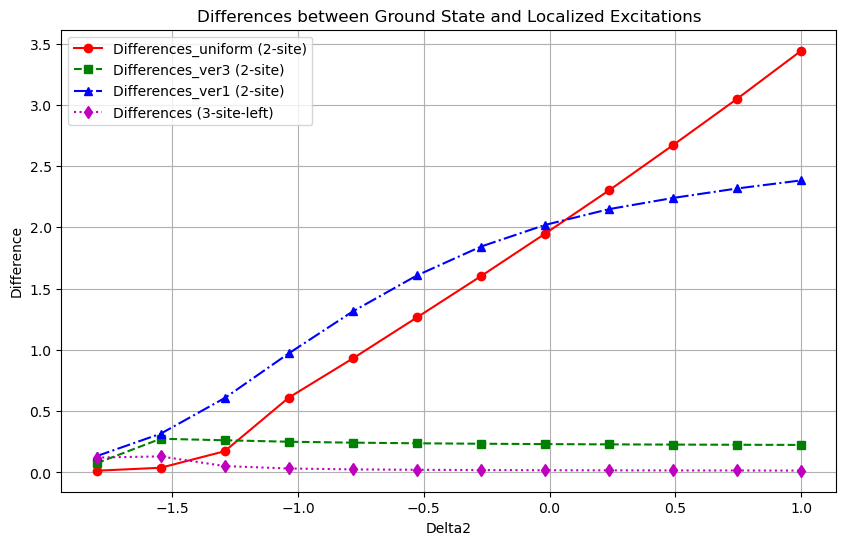

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 定义 Delta2_list_plus
Delta2_list_plus = np.linspace(-1.8, 1, 12)

# 定义差异数据
differences_uniform = [0.01375608643249393, 0.03791940838332408, 0.17290419878805352, 0.6102943048848815, 0.9300150867622641, 1.2643551928330818, 1.6013884672890732, 1.9477061922557937, 2.301493979015895, 2.671198905960125, 3.0488015331526697, 3.441159449848584]
differences_ver3 = [0.0748447873033804, 0.27466239105440415, 0.2621739987444016, 0.25034204973184515, 0.2427944180910906, 0.2376520152828654, 0.2338996770846986, 0.23104819372910868, 0.22880648297507378, 0.2270012068055376, 0.2255214583444829, 0.22431039530283847]
differences_ver1 = [0.13289873748376024, 0.31581053328337205, 0.6068572995395627, 0.9714202208722185, 1.3138170690787803, 1.6070853327453491, 1.8427735676657377, 2.019365951773313, 2.1484756420078455, 2.2396731493268476, 2.317007458747785, 2.382990853206749]
differences_3site_left = [0.12124691247448993, 0.13063501536005262, 0.05155374177027383, 0.031927647366018164, 0.024786911179702997, 0.021177671157346367, 0.01912809831489426, 0.01776811305301962, 0.01684844638059957, 0.016138462221423566, 0.015684843900924506, 0.014944066083579344]

# 绘制差异曲线
plt.figure(figsize=(10, 6))
plt.plot(Delta2_list_plus, differences_uniform, label="Differences_uniform (2-site)", linestyle='-', marker='o', color='r')
plt.plot(Delta2_list_plus, differences_ver3, label="Differences_ver3 (2-site)", linestyle='--', marker='s', color='g')
plt.plot(Delta2_list_plus, differences_ver1, label="Differences_ver1 (2-site)", linestyle='-.', marker='^', color='b')
plt.plot(Delta2_list_plus, differences_3site_left, label="Differences (3-site-left)", linestyle=':', marker='d', color='m')
plt.xlabel("Delta2")
plt.ylabel("Difference")
plt.title("Differences between Ground State and Localized Excitations")
plt.legend()
plt.grid()
plt.savefig("Differences_vs_Delta2_combined.png")
plt.show()

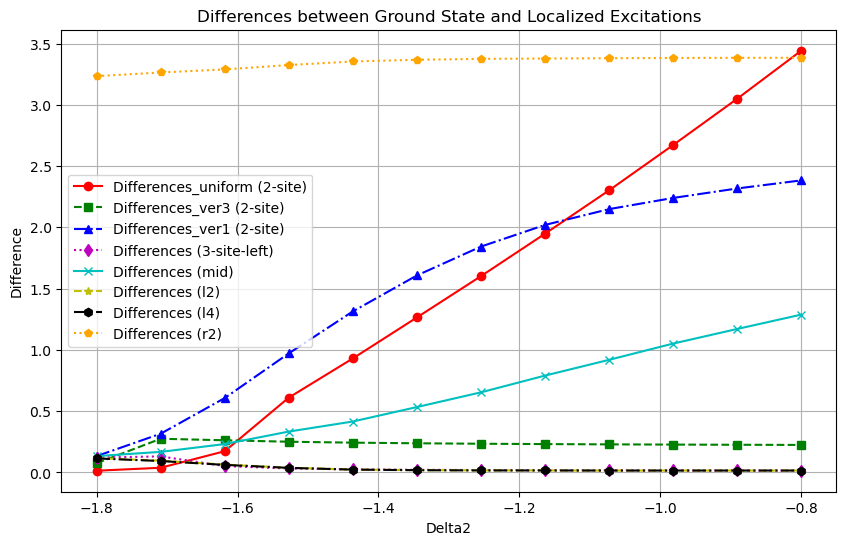

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 定义 Delta2_list_plus
Delta2_list_plus = np.linspace(-1.8, -0.8, 12)

# 定义差异数据
differences_uniform = [0.01375608643249393, 0.03791940838332408, 0.17290419878805352, 0.6102943048848815, 0.9300150867622641, 1.2643551928330818, 1.6013884672890732, 1.9477061922557937, 2.301493979015895, 2.671198905960125, 3.0488015331526697, 3.441159449848584]
differences_ver3 = [0.0748447873033804, 0.27466239105440415, 0.2621739987444016, 0.25034204973184515, 0.2427944180910906, 0.2376520152828654, 0.2338996770846986, 0.23104819372910868, 0.22880648297507378, 0.2270012068055376, 0.2255214583444829, 0.22431039530283847]
differences_ver1 = [0.13289873748376024, 0.31581053328337205, 0.6068572995395627, 0.9714202208722185, 1.3138170690787803, 1.6070853327453491, 1.8427735676657377, 2.019365951773313, 2.1484756420078455, 2.2396731493268476, 2.317007458747785, 2.382990853206749]
differences_3site_left = [0.12124691247448993, 0.13063501536005262, 0.05155374177027383, 0.031927647366018164, 0.024786911179702997, 0.021177671157346367, 0.01912809831489426, 0.01776811305301962, 0.01684844638059957, 0.016138462221423566, 0.015684843900924506, 0.014944066083579344]

# 新的差异数据
differences_mid = [0.13294134485609277, 0.1675335907875919, 0.23128733246856115, 0.333107813376877, 0.4153822780789582, 0.533245601468824, 0.6533103126174282, 0.7899690728827693, 0.9186033479147433, 1.0512462088406025, 1.1703383393131617, 1.2874624508610104]
differences_l2 = [0.11666236801943342, 0.09551024914907558, 0.06374677867903245, 0.038076026410358565, 0.023259181367361492, 0.018702868759305602, 0.016635337074319523, 0.016220741492158908, 0.015327054626482095, 0.015281154178936163, 0.015302232424264872, 0.01532999128031065]
differences_l4 = [0.11404391764560629, 0.09286410749015772, 0.06123933127139125, 0.03715516063871149, 0.022816029725259312, 0.01802640828124069, 0.016250115962286316, 0.015956128834567096, 0.015253311373957246, 0.015215700975630853, 0.015248402164107944, 0.015293566032976713]
differences_r2 = [3.233696754687136, 3.2634772506114036, 3.2886332711446133, 3.32432264226788, 3.3534472040580283, 3.3672674779230114, 3.374638774969622, 3.3774049691272374, 3.3798550137279193, 3.381959564331165, 3.3830455851721553, 3.383722314852047]

# 绘制差异曲线
plt.figure(figsize=(10, 6))
plt.plot(Delta2_list_plus, differences_uniform, label="Differences_uniform (2-site)", linestyle='-', marker='o', color='r')
plt.plot(Delta2_list_plus, differences_ver3, label="Differences_ver3 (2-site)", linestyle='--', marker='s', color='g')
plt.plot(Delta2_list_plus, differences_ver1, label="Differences_ver1 (2-site)", linestyle='-.', marker='^', color='b')
plt.plot(Delta2_list_plus, differences_3site_left, label="Differences (3-site-left)", linestyle=':', marker='d', color='m')
plt.plot(Delta2_list_plus, differences_mid, label="Differences (mid)", linestyle='-', marker='x', color='c')
plt.plot(Delta2_list_plus, differences_l2, label="Differences (l2)", linestyle='--', marker='*', color='y')
plt.plot(Delta2_list_plus, differences_l4, label="Differences (l4)", linestyle='-.', marker='h', color='k')
plt.plot(Delta2_list_plus, differences_r2, label="Differences (r2)", linestyle=':', marker='p', color='orange')
plt.xlabel("Delta2")
plt.ylabel("Difference")
plt.title("Differences between Ground State and Localized Excitations")
plt.legend()
plt.grid()
plt.savefig("Differences_vs_Delta2_combined.png")
plt.show()

## Uniform system

In [ ]:
from joblib import Parallel, delayed
import numpy as np
import matplotlib.pyplot as plt
import copy
import io
import os

# 参数设定
Ns = 192
Dp = 2
Ds = 14
Delta2_list_plus = np.linspace(-1.8, -0.8, 20)
Omega = 1

# 创建保存图像的文件夹
output_dir = "uniform_sys_localized_ex_box_of_1site"
os.makedirs(output_dir, exist_ok=True)

# 并行计算函数
def compute_energy_for_delta2(Delta2):
    buffer = io.StringIO()
    try:
        buffer.write('-------------------------------------------\n')
        buffer.write(f'Delta is: {Delta2}\n')
        
        # 初始化参数和 MPO
        Delta1 = Delta2
        Delta3 = Delta2
        Mpo1 = GetMpo_Kagome(Dp, Omega, Delta1, 15)
        Mpo3 = GetMpo_Kagome(Dp, Omega, Delta3, 15)
        Mpo2 = GetMpo_Kagome(Dp, Omega, Delta2, 15)
        Mpolist = Mpo_choose_version1(Mpo1, Mpo2, Mpo3, Ns)
        
        # 基态能量计算
        T = InitMps(Ns, Dp, Ds)
        HL, HR = IniH_multiple(Mpolist, T)
        T, Energy = OptT_multiple(Mpolist, HL, HR, T)
        E_total = Energy * Ns
        buffer.write(f'Energy is: {E_total}\n')
        T_ground = copy.deepcopy(T)

        # 1-site 局域激发态
        E_total_ex_1site, _ = localized_excitation(Mpolist, T_ground, 96, 96)
        buffer.write(f'1-site ex Energy is: {E_total_ex_1site}\n')

        # 2-site 局域激发态
        E_total_ex_2site, _ = localized_excitation(Mpolist, T_ground, 96, 97)
        buffer.write(f'2-site ex Energy is: {E_total_ex_2site}\n')

        # 4-site 局域激发态
        E_total_ex_4site, _ = localized_excitation(Mpolist, T_ground, 95, 98)
        buffer.write(f'4-site ex Energy is: {E_total_ex_4site}\n')

        return (
            E_total,
            E_total_ex_1site,
            E_total_ex_2site,
            E_total_ex_4site,
            buffer.getvalue(),
        )
    finally:
        buffer.close()

# 使用 joblib 并行化计算
results = Parallel(n_jobs=-1)(
    delayed(compute_energy_for_delta2)(Delta2) for Delta2 in Delta2_list_plus
)

# 分离结果
E_list_plus, E_list_ex_1site, E_list_ex_2site, E_list_ex_4site, outputs = zip(*results)

# 打印每个 Delta2 的输出
for output in outputs:
    print(output)

# 计算差异
differences_1site = np.abs(np.array(E_list_plus) - np.array(E_list_ex_1site))
differences_2site = np.abs(np.array(E_list_plus) - np.array(E_list_ex_2site))
differences_4site = np.abs(np.array(E_list_plus) - np.array(E_list_ex_4site))

# 保存数据到文件
with open(f"{output_dir}/energy_info.txt", "w") as f:
    f.write("E_list:\n")
    f.write(", ".join(map(str, E_list_plus)) + "\n\n")
    f.write("E_list_ex_1site:\n")
    f.write(", ".join(map(str, E_list_ex_1site)) + "\n\n")
    f.write("E_list_ex_2site:\n")
    f.write(", ".join(map(str, E_list_ex_2site)) + "\n\n")
    f.write("E_list_ex_4site:\n")
    f.write(", ".join(map(str, E_list_ex_4site)) + "\n\n")
    f.write("Differences (1-site):\n")
    f.write(", ".join(map(str, differences_1site)) + "\n\n")
    f.write("Differences (2-site):\n")
    f.write(", ".join(map(str, differences_2site)) + "\n\n")
    f.write("Differences (4-site):\n")
    f.write(", ".join(map(str, differences_4site)) + "\n\n")

# 绘制差异曲线
plt.figure(figsize=(10, 6))
plt.plot(Delta2_list_plus, differences_1site, label="1-site Difference")
plt.scatter(Delta2_list_plus, differences_1site, c="r", s=20)
plt.plot(Delta2_list_plus, differences_2site, label="2-site Difference")
plt.scatter(Delta2_list_plus, differences_2site, c="g", s=20)
plt.plot(Delta2_list_plus, differences_4site, label="4-site Difference")
plt.scatter(Delta2_list_plus, differences_4site, c="b", s=20)
plt.xlabel("Delta2")
plt.ylabel("Difference")
plt.title("Difference between Ground State and Localized Excitations")
plt.legend()
plt.grid()
plt.savefig(f"{output_dir}/Difference_vs_Delta2_combined.png")
plt.close()

# 绘制每种局域激发能量
plt.figure(figsize=(10, 6))
plt.plot(Delta2_list_plus, E_list_plus, label="Ground State Energy")
plt.scatter(Delta2_list_plus, E_list_plus, c="r", s=20)
plt.plot(Delta2_list_plus, E_list_ex_1site, label="1-site Excitation Energy", linestyle="--")
plt.plot(Delta2_list_plus, E_list_ex_2site, label="2-site Excitation Energy", linestyle="-.")
plt.plot(Delta2_list_plus, E_list_ex_4site, label="4-site Excitation Energy", linestyle=":")
plt.xlabel("Delta2")
plt.ylabel("Energy")
plt.title("Ground and Excitation Energies vs Delta2")
plt.legend()
plt.grid()
plt.savefig(f"{output_dir}/Energy_vs_Delta2_combined.png")
plt.close()

In [ ]:
from joblib import Parallel, delayed
import numpy as np
import matplotlib.pyplot as plt
import copy
import io
import os

# 参数设定
Ns = 192
Dp = 2
Ds = 14
Delta2_list_plus = np.linspace(-1.8, -0.8, 20)
Omega = 1

# 创建保存图像的文件夹
output_dir = "localized_ex_box_of_2site"
os.makedirs(output_dir, exist_ok=True)


# 并行计算函数
def compute_energy_for_delta2(Delta2):
    # 创建一个临时字符串缓冲区用于存储输出
    buffer = io.StringIO()
    try:
        buffer.write('-------------------------------------------\n')
        buffer.write(f'Delta is: {Delta2}\n')
        
        # 初始化参数和 MPO
        Delta1 = -1.8
        Delta3 = 1
        Mpo1 = GetMpo_Kagome(Dp, Omega, Delta1, 15)
        Mpo3 = GetMpo_Kagome(Dp, Omega, Delta3, 15)
        Mpo2 = GetMpo_Kagome(Dp, Omega, Delta2, 15)
        Mpolist = Mpo_choose_version1(Mpo1, Mpo2, Mpo3, Ns)
        
        # 基态能量计算
        T = InitMps(Ns, Dp, Ds)
        HL, HR = IniH_multiple(Mpolist, T)
        T, Energy = OptT_multiple(Mpolist, HL, HR, T)
        E_total = Energy * Ns
        buffer.write(f'Energy is: {E_total}\n')
        T_ground = copy.deepcopy(T)

        # 局域激发态能量计算
        
        E_total_ex,_ = localized_excitation(Mpolist,T_ground,96,97)    ##### 这个是灵活调整的部分
        buffer.write(f'ex Energy is: {E_total_ex}\n')
        return E_total, E_total_ex, buffer.getvalue()
    finally:
        buffer.close()

# 使用 joblib 并行化计算
results = Parallel(n_jobs=-1)(delayed(compute_energy_for_delta2)(Delta2) for Delta2 in Delta2_list_plus)

# 分离结果
E_list_plus, E_list_ex_plus, outputs = zip(*results)

# 打印每个 Delta2 的输出
for output in outputs:
    print(output)

# 找到最小差距和对应的 Delta2
differences = np.abs(np.array(E_list_plus) - np.array(E_list_ex_plus))
min_diff = np.min(differences)
min_diff_index = np.argmin(differences)
min_Delta2 = Delta2_list_plus[min_diff_index]

print("E_list:", E_list_plus)
print("E_list_ex:", E_list_ex_plus)
print(f"最小差距为: {min_diff}，对应的 Delta2 为: {min_Delta2}")

# 将信息写入文件
with open(f"{output_dir}/energy_info.txt", "w") as f:
    f.write("E_list:\n")
    f.write(", ".join(map(str, E_list_plus)) + "\n\n")
    f.write("E_list_ex:\n")
    f.write(", ".join(map(str, E_list_ex_plus)) + "\n\n")
    f.write("Difference:\n")
    f.write(", ".join(map(str, differences)) + "\n\n")
    f.write(f"最小差距为: {min_diff}，对应的 Delta2 为: {min_Delta2}\n")

# 绘制能量图
plt.plot(Delta2_list_plus, E_list_plus, label='Energy')
plt.scatter(Delta2_list_plus, E_list_plus, c='r')
plt.plot(Delta2_list_plus, E_list_ex_plus, label='ex Energy', linestyle='--')
plt.scatter(Delta2_list_plus, E_list_ex_plus, c='r')
plt.xlabel('Delta2')
plt.ylabel('Energy')
plt.title('Energy and ex Energy vs Delta2')
plt.legend()
plt.savefig(f"{output_dir}/Energy_vs_Delta2.png")
plt.close()

# 绘制能量差异图
diff = differences
plt.plot(Delta2_list_plus, diff, label='Difference')
plt.scatter(Delta2_list_plus, diff, c='r')
plt.xlabel('Delta2')
plt.ylabel('Difference')
plt.title('Difference between Energy and ex Energy')
plt.legend()
plt.savefig(f"{output_dir}/Difference_vs_Delta2.png")
plt.close()


(-40.11171851041, -40.126909484813176, -40.146215917275526, -40.17382522501879, -40.2143928344077, -40.27010051505982, -40.339655469429786, -40.4190192865898, -40.50513111368432, -40.595871517996976, -40.689728873005386, -40.78579092844211, -40.883493061171166, -40.98243419743339, -41.08231254854116, -41.18290659079219, -41.284105916802076, -41.38578589390717, -41.487863843425835, -41.59025039500521)
(array([-40.11171851]), array([-40.12690948]), array([-40.14621592]), array([-40.17382523]), array([-40.21439283]), array([-40.27010052]), array([-40.33965547]), array([-40.41901929]), array([-40.50513111]), array([-40.59587152]), array([-40.68972887]), array([-40.78579093]), array([-40.88349306]), array([-40.9824342]), array([-41.08231255]), array([-41.18290659]), array([-41.28410592]), array([-41.38578589]), array([-41.48786384]), array([-41.5902504]))


修改ing

In [ ]:
Ns = 32
Dp = 2
Ds = 14
Delta2 = -1.5
Omega = 1
Delta1 = -1.5
Delta3 = -1.5
Mpo1 = GetMpo_Kagome(Dp, Omega, Delta1, 10)
Mpo3 = GetMpo_Kagome(Dp, Omega, Delta3, 10)
Mpo2 = GetMpo_Kagome(Dp, Omega, Delta2, 10)
Mpolist = Mpo_choose_version1(Mpo1, Mpo2, Mpo3, Ns)
T = InitMps(Ns, Dp, Ds)
HL, HR = IniH_multiple(Mpolist, T)
T, Energy = OptT_multiple(Mpolist, HL, HR, T)
E_total = Energy * Ns
print('E_total',E_total)
T_ground = copy.deepcopy(T)

Sweep: 0
Sweep: 1
Sweep: 2
Sweep: 3
Sweep: 4
Sweep: 5
Sweep: 6
Sweep: 7
Sweep: 8
Sweep: 9
Sweep: 10
Sweep: 11
Sweep: 12
Sweep: 13
Sweep: 14
Sweep: 15
Sweep: 16
Sweep: 17
Sweep: 18
Sweep: 19
Sweep: 20
Sweep: 21
Sweep: 22
Sweep: 23
E_total 17.950191287969105


In [ ]:
Ns = 32
Dp = 2
Ds = 6
Delta = -1.5
Omega = 1.0
Mpo = GetMpo_Kagome(Dp, Omega, Delta, 10)
T_ancient = InitMps(Ns, Dp, Ds)
HL, HR = IniH(Mpo, T_ancient)
T_ancient, Energy = OptT_naive(Mpo, HL, HR, T_ancient)      #原始版本

Sweep: 0
Sweep: 1
Sweep: 2
Sweep: 3
Sweep: 4
Sweep: 5
Sweep: 6
Sweep: 7
Sweep: 8
Sweep: 9
Sweep: 10


In [ ]:
T_ground_ground = copy.deepcopy(T)

In [ ]:
T_ground = T_ground_ground

In [ ]:
Inner_product_MPS(T_ground,T_ancient)

array(0.61442841)

In [ ]:
print(Energy*Ns)

125.87537662102352


In [ ]:
#最后一搏！！！！！！！！！！！！！！

def localized_excitation_god(Mpo_list,T_ground_state,start_index,end_index):
    T_ground = copy.deepcopy(T_ground_state)   # 万万不能直接赋值，这样只是引用，会导致T_ground_state被改变
    #print('st1',Sub.NCon([T_ground[start_index],np.conj(T_ground[start_index])],[[1,2,3],[1,2,3]]))
    Ns = len(T_ground)
    Dmpo = np.shape(Mpo_list[0])[0]
    HL = [None]*Ns
    HR = [None]*Ns
    HL[0] = np.zeros((1,Dmpo,1))
    HL[0][0,0,0] = 1.0
    HR[-1] = np.zeros((1,Dmpo,1))
    HR[-1][0,-1,0] = 1.0
    for i in range(Ns-1,0,-1):   #获得一个HR[end_index]
        #HR[i-1] = Sub.NCon([HR[i],T_ground[i],Mpo_list[i],np.conj(T_ground[i])],[[1,3,5],[-1,2,1],[-2,2,3,4],[-3,4,5]])
        U,T_ground[i] = Sub.Mps_LQ0P(T_ground[i])
        T_ground[i-1] = np.tensordot(T_ground[i-1],U,(2,0))
        HR[i-1] = Sub.NCon([HR[i],T_ground[i],Mpo_list[i],np.conj(T_ground[i])],[[1,3,5],[-1,2,1],[-2,2,3,4],[-3,4,5]])
    #print('st2',Sub.NCon([T_ground[start_index],np.conj(T_ground[start_index])],[[1,2,3],[1,2,3]]))
    for i in range(start_index):   #获得一个HL[start_index]
        T_ground[i],U = Sub.Mps_QR0P(T_ground[i])
        T_ground[i+1] = np.tensordot(U,T_ground[i+1],(1,0))
        HL[i+1] = Sub.NCon([HL[i],np.conj(T_ground[i]),Mpo_list[i],T_ground[i]],[[1,3,5],[1,2,-1],[3,4,-2,2],[5,4,-3]])
    #print('st3',Sub.NCon([T_ground[start_index],np.conj(T_ground[start_index])],[[1,2,3],[1,2,3]]))
    #print('st4',Sub.NCon([T_ground[end_index],np.conj(T_ground[end_index])],[[1,2,3],[1,2,3]]))
    '''
    middle_H = Mpo_list[start_index]
    for i in range(start_index,end_index):
        print('here is one',i)
        middle_H = Sub.NCon([middle_H,Mpo_list[i+1]],[[-1,-2,1,-6],[1,-3,-4,-5]])
        middle_H = Sub.Group(middle_H,[[0],[1,2],[3],[4,5]])
    print('shape',np.shape(middle_H))
    Mat = Sub.NCon([HL[start_index],Mpo_list[start_index],Mpo_list[end_index],HR[end_index]],[[-1,1,-5],[1,-6,3,-2],[3,-7,2,-3],[-8,2,-4]])
    Mat = Sub.Group(Mat,[[0,1,2,3],[4,5,6,7]])
    
    vec = Sub.NCon([T_ground[start_index],T_ground[end_index]],[[-1,-2,1],[1,-3,-4]])
    vec = Sub.Group(vec,[[0,1,2,3]])
    print('shape',np.shape(vec))
    print('shape',np.shape(Mat))
    print('Value',Sub.NCon([vec,Mat,np.conj(vec)],[[2],[1,2],[1]]))
    '''
    
    HL_star = Sub.NCon([HL[start_index],Mpo_list[start_index]],[[-1,1,-2],[1,-3,-4,-5]])
    HL_star = Sub.Group(HL_star,[[0,4],[3],[1,2]])
    for i in range(start_index,end_index):
        i_star = i+1
        HL_star = Sub.NCon([HL_star,Mpo_list[i_star]],[[-1,1,-2],[1,-3,-4,-5]])
        HL_star = Sub.Group(HL_star,[[0,4],[3],[1,2]])
    Mat = Sub.NCon([HL_star,HR[end_index]],[[-1,1,-3],[-4,1,-2]])
    Mat = Sub.Group(Mat,[[0,1],[2,3]])  
    '''
    vec = T_ground[start_index]
    for i in range(start_index,end_index):
        vec = Sub.NCon([vec,T_ground[i+1]],[[-1,-2,1],[1,-3,-4]])
        vec = Sub.Group(vec,[[0],[1,2],[3]])
    vec = Sub.Group(vec,[[0,1,2]])
    print('shape',np.shape(vec))
    print('shape',np.shape(Mat))
    print('Value_kk',Sub.NCon([vec,Mat,np.conj(vec)],[[2],[1,2],[1]]))
    
    print('shape = ',np.shape(Mat))
    '''
    #print('shape',np.shape(Mat))
    #print(np.shape(Mat))
    Eig ,V = eigsh(Mat, k=2, which='SA')
    # 提取第二小的特征值
    first_E = Eig[0]
    second_smallest_eigenvalue = Eig[1]
    
    return second_smallest_eigenvalue,first_E

In [ ]:
E_total_ex,E_first = localized_excitation_god(Mpolist,T_ground,15,18)
print('E_first',E_first)
print('E_total',E_total_ex)

E_total_ex,E_first = localized_excitation_shit(Mpolist,T_ground,18,18)
print('E_first',E_first)
print('E_total',E_total_ex)

shape (3136,)
shape (3136, 3136)
Value_kk 17.95019128796951
E_first 17.950179634771896
E_total 18.00079033930133
shape (8, 2, 8, 2)
E_first 17.9501912879644
E_total 18.00163135157849


In [ ]:
start_index = 17
end_index = 18
Mpo_list = Mpolist
Ns = len(T_ground)
Dmpo = np.shape(Mpolist[0])[0]
HL = [None]*Ns
HR = [None]*Ns
HL[0] = np.zeros((1,Dmpo,1))
HL[0][0,0,0] = 1.0
HR[-1] = np.zeros((1,Dmpo,1))
HR[-1][0,-1,0] = 1.0
for i in range(Ns-1,0,-1):   #获得一个HR[end_index]
    #HR[i-1] = Sub.NCon([HR[i],T_ground[i],Mpo_list[i],np.conj(T_ground[i])],[[1,3,5],[-1,2,1],[-2,2,3,4],[-3,4,5]])
    U,T_ground[i] = Sub.Mps_LQ0P(T_ground[i])
    T_ground[i-1] = np.tensordot(T_ground[i-1],U,(2,0))
    HR[i-1] = Sub.NCon([HR[i],T_ground[i],Mpo_list[i],np.conj(T_ground[i])],[[1,3,5],[-1,2,1],[-2,2,3,4],[-3,4,5]])



for i in range(start_index):   #获得一个HL[start_index]
    T_ground[i],U = Sub.Mps_QR0P(T_ground[i])
    T_ground[i+1] = np.tensordot(U,T_ground[i+1],(1,0))
    HL[i+1] = Sub.NCon([HL[i],np.conj(T_ground[i]),Mpo_list[i],T_ground[i]],[[1,3,5],[1,2,-1],[3,4,-2,2],[5,4,-3]])

HL[start_index+1] = Sub.NCon([HL[start_index],np.conj(T_ground[start_index]),Mpo_list[start_index],T_ground[start_index]],[[1,3,5],[1,2,-1],[3,4,-2,2],[5,4,-3]])
print('guuu',Sub.NCon([HL[start_index+1],HR[start_index]],[[1,2,3],[3,2,1]]))
print('gu',Sub.NCon([HL[start_index],T_ground[start_index],T_ground[start_index+1],HR[end_index],np.conj(T_ground[end_index]),np.conj(T_ground[start_index]),Mpo_list[start_index],Mpo_list[end_index]],[[3,2,1],[1,10,4],[4,11,7],[7,8,9],[6,13,9],[3,12,6],[2,10,5,12],[5,11,8,13]]))

TT = Sub.NCon([T_ground[start_index],T_ground[end_index]],[[-1,-2,1],[1,-3,-4]])
MM = Sub.NCon([Mpo_list[start_index],Mpo_list[end_index]],[[-1,-2,1,-6],[1,-3,-4,-5]])
print('GTK',Sub.NCon([HL[start_index],TT,MM,np.conj(TT),HR[end_index]],[[9,5,1],[1,2,3,4],[5,2,3,6,7,8],[9,7,8,10],[4,6,10]]))
print('GUtiankuo',Sub.NCon([HL[start_index],TT,Mpo_list[start_index],Mpo_list[end_index],np.conj(TT),HR[end_index]],[[9,5,1],[1,2,3,4],[5,2,11,7],[11,3,6,8],[9,7,8,10],[4,6,10]]))

middle_H = Mpo_list[start_index]
for i in range(start_index,end_index):
    print('here is one',i)
    middle_H = Sub.NCon([middle_H,Mpo_list[i+1]],[[-1,-2,1,-6],[1,-3,-4,-5]])
    middle_H = Sub.Group(middle_H,[[0],[1,2],[3],[4,5]])
Mat = Sub.NCon([HL[start_index],middle_H,HR[end_index]],[[-1,1,-4],[1,-5,2,-2],[-6,2,-3]])
Mat = Sub.Group(Mat,[[0,1,2],[3,4,5]])



vec = Sub.NCon([T_ground[start_index],T_ground[end_index]],[[-1,-2,1],[1,-3,-4]])
vec = Sub.Group(vec,[[0,1,2,3]])
print('shape',np.shape(vec))
print('shape',np.shape(Mat))
print('Value',Sub.NCon([vec,Mat,np.conj(vec)],[[2],[1,2],[1]]))

Mat = Sub.NCon([HL[start_index],Mpo_list[start_index],Mpo_list[end_index],HR[end_index]],[[-1,1,-5],[1,-6,3,-2],[3,-7,2,-3],[-8,2,-4]])
Mat = Sub.Group(Mat,[[0,1,2,3],[4,5,6,7]])
print('-----------------------------------')
vec = Sub.NCon([T_ground[start_index],T_ground[end_index]],[[-1,-2,1],[1,-3,-4]])
vec = Sub.Group(vec,[[0,1,2,3]])
print('shape',np.shape(vec))
print('shape',np.shape(Mat))
print('Value',Sub.NCon([vec,Mat,np.conj(vec)],[[2],[1,2],[1]]))

guuu 17.950191287969506
gu 17.95019128796951
GTK 14.300217938645574
GUtiankuo 17.950191287969496
here is one 17
shape (784,)
shape (784, 784)
Value 14.300217938645572
-----------------------------------
shape (784,)
shape (784, 784)
Value 17.950191287969496


## 尝试新方法

In [ ]:
num = 2
Ns_original = 12
Ns = Ns_original//num  # 新的长度
Dp_original = 2
Dp = Dp_original**num  # 新的Dp
#print('Dp',Dp)
Ds = 14
Delta2 = -10
Omega = 1
Delta1 = Delta2
Delta3 = Delta2
Mpo1 = GetMpo_Kagome(2, Omega, Delta1, 10)
Mpo3 = GetMpo_Kagome(2, Omega, Delta3, 10)
Mpo2 = GetMpo_Kagome(2, Omega, Delta2, 10)

Mpolist = Mpo_choose_version1(Mpo1, Mpo2, Mpo3, Ns_original)
Mpolist_combined = combined_MPO(Mpolist, num)
#print('len',len(Mpolist_combined))
T_combined = InitMps(Ns, Dp, Ds)
#print(np.shape(Mpolist_combined[1]))
#print(len(T_combined))
HL, HR = IniH_multiple(Mpolist_combined, T_combined)
T_combined, Energy = OptT_multiple(Mpolist_combined, HL, HR, T_combined)
E_total = Energy * Ns
print('E_total',E_total)
print('E_single',E_total/Ns_original)
T_ground_com = copy.deepcopy(T_combined)

Sweep: 0
Sweep: 1
E_total -2300.0266131120575
E_single -191.66888442600478


In [ ]:
Ns_original = 32
Ds = 6
Dp_original = 2
Omega = 1
Delta2 = -10
Mpo = GetMpo_Kagome(Dp_original, Omega, Delta2, 18)
T_ancient = InitMps(Ns_original, Dp_original, Ds)
HL, HR = IniH(Mpo, T_ancient)
T_ancient, Energy = OptT_naive(Mpo, HL, HR, T_ancient)      #原始版本
print(Energy)

Sweep: 0
Sweep: 1
Sweep: 2
Sweep: 3
4.359821859634805
Sweep: 0
Sweep: 1
Sweep: 2
4.360938565013183
